In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pqcd
import pickle

from pqcd.utils import (
    rcparams,
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre,
    dyn_per_square_cm_to_GeV_per_cubic_femtometer,
    GeV_per_cubic_femtometer_to_dyn_per_square_cm,
    nsat
    )

from cmcrameri import cm
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from matplotlib.colors import ListedColormap

plt.rcParams.update(rcparams)

In [2]:
# Some example (mu [GeV], n [1/fm^3], p [GeV/fm^3]) values for chiEFT
CET_values = {
    'soft': [0.966, 0.176, 2.163/1000],
    'stiff': [0.978, 0.176, 3.542/1000]
}

muL, nL, pL = CET_values['soft']
epsilonL = pqcd.epsilon_func(muL, nL, pL)

In [3]:
muH = 2.6
mu_array = np.linspace(muL, muH, 1000)

In [4]:
with open('../data/eos-extensions/eos_extensions_s-G-1p25-0p25_l-U-1-20_meancs2-G-0.3-0.3_pQCD-25-40.pickle', 'rb') as f:
    eos_extensions = pickle.load(f)

eos_extensions['n'] = (eos_extensions['p'] + eos_extensions['e'])/eos_extensions['mu']

In [5]:
n0 = 10*nsat

In [6]:
e_kde = []
p_kde = []
for index, eos in eos_extensions.iterrows():
    highlight_index = np.argmin((eos.n[:-1]-n0)**2)
    e_kde.append(eos.e[highlight_index])
    p_kde.append(eos.p[highlight_index])

In [7]:
kde = gaussian_kde(np.vstack((e_kde, p_kde)))

In [9]:
xlim = (0.13471795348380078, 17.002209254489188)
ylim = (0.0014798402249155988, 6.262273589369166)

In [10]:
e_kde = np.array(e_kde)
p_kde = np.array(p_kde)

# Stack the data into a 2D array
data = np.vstack([e_kde, p_kde])

# Create the KDE
kde = gaussian_kde(data)

# Generate a grid over which to evaluate the KDE
x_min, x_max = xlim[0], xlim[1]
y_min, y_max = ylim[0], ylim[1]
X, Y = np.mgrid[x_min:x_max:1000j, y_min:y_max:1000j]
positions = np.vstack([X.ravel(), Y.ravel()])

# Evaluate the KDE on the grid
Z = np.reshape(kde(positions).T, X.shape)

In [11]:
# Define the number of colors in the colormap
ncolors = 256

# Create an array for RGBA values
colors = np.zeros((ncolors, 4))

# Set RGB values to 0 (black)
colors[:, 0] = 0  # Red channel
colors[:, 1] = 0  # Green channel
colors[:, 2] = 0  # Blue channel

# Set alpha values to transition from 0 (transparent) to 1 (opaque)
colors[:, 3] = np.linspace(0, 1, ncolors)

# Create the custom colormap
transparent_to_black = ListedColormap(colors, name='TransparentToBlack')

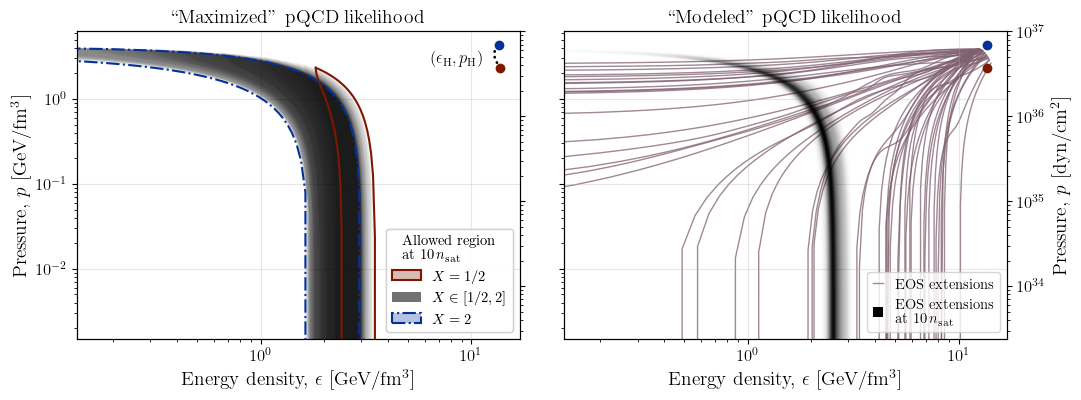

In [22]:
X_border_list = [0.5, 2]

X_list = []
for i in range(50):
    logX = np.random.uniform(np.log(1/2), np.log(2))
    X_list.append(np.exp(logX))
X_list = [X_border_list[0]] + sorted(X_list) + [X_border_list[1]]

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.subplots_adjust(wspace=0.1)
for ax in axs:
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3)

for ax in axs:

    ax.set_xscale('log')
    ax.set_yscale('log')

    # ax.plot(
    #     epsilonL, 
    #     pL, 
    #     'o', 
    #     c=cm.roma(0.9), 
    #     zorder=5 
    #     )

    # ax.text(
    #     epsilonL+0.015, 
    #     pL+1e-3, 
    #     r'$(\epsilon_\mathrm{L}, p_\mathrm{L})$', 
    #     c=cm.roma(0.9)
    #     )

pH_list = []
epsilonH_list = []

for i, X in enumerate(X_list):

    pQCDX = pqcd.pQCD(X)
    nH, pH = pQCDX.nH(muH), pQCDX.pH(muH)
    epsilonH = pqcd.epsilon_func(muH, nH, pH)

    pH_list.append(pH)
    epsilonH_list.append(epsilonH)

    constraints = pqcd.constraints(muL, nL, pL, muH, nH, pH)

    c = cm.roma(i/(len(X_list)-1))

    epsilon_min = constraints.epsilon_min(mu_array)
    p_max = constraints.pmax(mu_array, constraints.nmin(mu_array))
    
    epsilon_max = constraints.epsilon_max(mu_array)
    p_min = constraints.pmin(mu_array)

    if (i == 0) or (i == len(X_list)-1):

        for ax in axs:

            alpha = 0.25
            ls = '--'
            zorder = 0.5

            # ax.plot(
            #     np.concatenate((epsilon_min, [constraints.epsilonH])), 
            #     np.concatenate((p_max, [constraints.pH])),
            #     c=c,
            #     alpha=alpha,
            #     ls=ls,
            #     zorder=zorder
            #     )
            
            # ax.plot(
            #     np.concatenate(([constraints.epsilonL], epsilon_max)), 
            #     np.concatenate(([constraints.pL], p_min)),
            #     c=c,
            #     alpha=alpha,
            #     ls=ls,
            #     zorder=zorder
            #     )
            
            ax.plot(
                constraints.epsilonH, 
                constraints.pH, 
                'o', 
                c=c, 
                )

    mu0 = np.linspace((n0/nH)*muH, muH, num=100)

    p0_min = pH - (1/2)*(nH/muH)*(muH**2 - mu0**2)
    epsilon0_min = mu0*n0 - p0_min

    p0_max = pH - (1/2)*(n0/mu0)*(muH**2 - mu0**2)
    epsilon0_max = mu0*n0 - p0_max

    p0_max_interp = interp1d(epsilon0_max, p0_max, bounds_error=False)

    axs[0].fill_between(
        epsilon0_min, 
        y1=p0_max_interp(epsilon0_min), 
        y2=p0_min, 
        color='k', 
        alpha=0.035, 
        lw=0,
        # zorder=0.5
    )

    alpha = 1
    zorder = 10

    for ax in axs[:1]:

        if X == 0.5:
            ax.plot(epsilon0_min, p0_min, c=cm.roma(0.0), alpha=alpha, ls='-', zorder=zorder)
            ax.plot(epsilon0_max, p0_max, c=cm.roma(0.0), alpha=alpha, ls='-', zorder=zorder)

        if X == 2:
            ax.plot(epsilon0_min, p0_min, c=cm.roma(1.0), alpha=alpha, ls='-.', zorder=zorder)
            ax.plot(epsilon0_max, p0_max, c=cm.roma(1.0), alpha=alpha, ls='-.', zorder=zorder)

axs[1].imshow(
    np.rot90(Z), 
    extent=[x_min, x_max, y_min, y_max], 
    cmap=transparent_to_black,
    aspect='auto',
    zorder=1
)

# Conditioned GP draws
# --------------------

N_samp = 50
label_added = False
for index, eos in eos_extensions.sample(N_samp).iterrows():
    if not label_added:
        label = 'EOS extensions'
        label_added = True
    else:
        label = None
    axs[1].plot(eos.e, eos.p, c=cm.lipari(0.4), alpha=0.75, zorder=0.25, lw=1, label=label)
    highlight_index = np.argmin((eos.n[:-1]-n0)**2)

axs[0].plot(
    epsilonH_list, 
    pH_list, 
    c='k', 
    zorder=0.1, 
    lw=2,
    linestyle=(0,(0.1,2)),
    dash_capstyle='round'
)

for ax in axs:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

twinx = axs[1].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

twinx = axs[0].twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(axs[1].get_ylim())))
twinx.set_yticklabels([])

# ---

axs[0].text(
    0.8, 
    0.9, 
    r'$(\epsilon_\mathrm{H},p_\mathrm{H})$', 
    transform=axs[0].transAxes,
    fontsize=12
)

# ---

custom_handles = [
    mpatches.Patch(
        facecolor=list(cm.roma(0.0))[:3]+[0.25],
        edgecolor=cm.roma(0.0),
        lw=1.5,
        linestyle='-'
    ),
    mpatches.Patch(
        facecolor=[0,0,0,0.5], 
        edgecolor='k', 
        fill=True, 
        lw=0, 
    ),
    mpatches.Patch(
        facecolor=list(cm.roma(1.0))[:3]+[0.25],
        edgecolor=cm.roma(1.0),
        lw=1.5,
        linestyle='-.'
    ),
]

custom_labels = [
    '$X = 1/2$',
    '$X \in [1/2,2]$',
    '$X = 2$',
]

l1 = axs[0].legend(
    custom_handles, 
    custom_labels, 
    loc='lower right', 
    title='Allowed region\nat $10\,n_\\mathrm{sat}$', 
    fontsize=10.5, 
    title_fontsize=10.5,
    # bbox_to_anchor=(1,0.17)
)

axs[0].add_artist(l1)

# custom_handles = [
#     mpatches.Patch(color=cm.roma(0.), linestyle='-'),
#     mpatches.Patch(color='k'),
#     mpatches.Patch(color=cm.roma(1.), linestyle='-.')
# ]

# custom_labels = [
#     '$X = 1/2$',
#     '$X \in [1/2,2]$',
#     '$X = 2$',
# ]

# l1 = axs[0].legend(
#     custom_handles,
#     custom_labels,
#     loc='lower right',
#     numpoints=1,
#     handlelength=0.7,
#     # handletextpad=0.1,
#     bbox_to_anchor=(1,0.22),
#     fontsize=10.5
#     )

# axs[0].add_artist(l1)

# custom_handles = [
#     plt.Line2D([0], [0], marker='o', c='k', lw=0),
#     mpatches.Patch(color='k', fill=False, lw=1.5),
# ]

# custom_labels = [
#     r'$(\epsilon_\mathrm{H},p_\mathrm{H})$',
#     'Allowed region\nat $10 n_\\mathrm{sat}$',
# ]

# l2 = axs[0].legend(
#     custom_handles,
#     custom_labels,
#     loc='lower right',
#     handlelength=0.7,
#     # handletextpad=0.1,
#     bbox_to_anchor=(1,0),
#     fontsize=10.5
#     )

custom_handles = [
    plt.Line2D([0], [0], c=cm.lipari(0.4), alpha=0.75, lw=1,),
    mpatches.Patch(color='k', fill=True, lw=0),
]

custom_labels = [
    'EOS extensions',
    'EOS extensions\nat $10\,n_\\mathrm{sat}$',
]

axs[1].legend(custom_handles, custom_labels, loc='lower right', handlelength=0.7, fontsize=10.5)

for ax in axs:
    ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')

axs[0].set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

axs[0].set_title('``Maximized" pQCD likelihood')
axs[1].set_title('``Modeled" pQCD likelihood')

fig.savefig('figures/paper/max_vs_marg.pdf', bbox_inches='tight');

In [14]:
muL, nL, pL = CET_values['stiff']
epsilonL = pqcd.epsilon_func(muL, nL, pL)

muH = 2.6
mu_array = np.linspace(muL, muH, 1000)

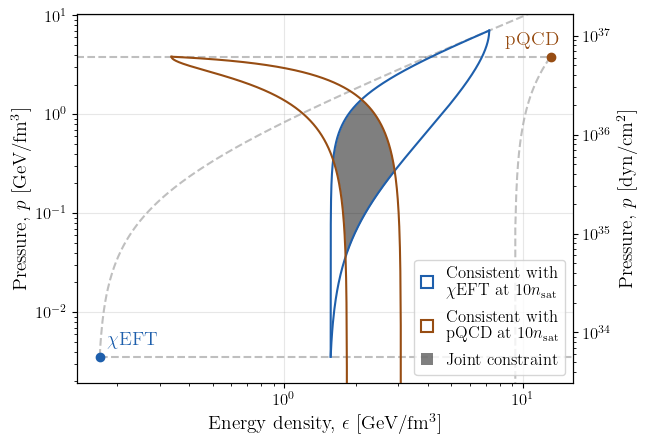

In [20]:
fig, ax = plt.subplots()

ax.set_axisbelow(True)
ax.grid(alpha=0.3)

ax.set_xscale('log')
ax.set_yscale('log')

cL = cm.roma(0.9)
cH = cm.roma(0.1)

# Low density marker
# ------------------

ax.plot(
    epsilonL, 
    pL, 
    'o', 
    c=cL, 
    zorder=5 
    )

ax.text(
    epsilonL+0.013, 
    pL+1.1e-3, 
    # r'$(\epsilon_\mathrm{L}, p_\mathrm{L})$', 
    '$\chi$EFT',
    c=cL
    )

# High density marker
# ------------------- 

X = 1

pQCDX = pqcd.pQCD(X)
nH, pH = pQCDX.nH(muH), pQCDX.pH(muH)
epsilonH = pqcd.epsilon_func(muH, nH, pH)

constraints = pqcd.constraints(muL, nL, pL, muH, nH, pH)

epsilon_min = constraints.epsilon_min(mu_array)
p_max = constraints.pmax(mu_array, constraints.nmin(mu_array))

epsilon_max = constraints.epsilon_max(mu_array)
p_min = constraints.pmin(mu_array)

ax.plot(
    constraints.epsilonH, 
    constraints.pH, 
    'o', 
    c=cH, 
    )

ax.text(
    epsilonH+1, 
    pH+1.2, 
    # r'$(\epsilon_\mathrm{H}, p_\mathrm{H})$', 
    'pQCD',
    c=cH,
    ha='right'
    )

# Overall allowed region
# ----------------------

c = 'k'
alpha = 0.25
ls = '--'
zorder = 0.5

# ax.plot(
#     np.concatenate((epsilon_min, [constraints.epsilonH])), 
#     np.concatenate((p_max, [constraints.pH])),
#     c=c,
#     alpha=alpha,
#     ls=ls,
#     zorder=zorder
#     )

# ax.plot(
#     np.concatenate(([constraints.epsilonL], epsilon_max)), 
#     np.concatenate(([constraints.pL], p_min)),
#     c=c,
#     alpha=alpha,
#     ls=ls,
#     zorder=zorder
#     )

# chiEFT allowed region
# ---------------------

mu0 = np.linspace(muL, (n0/nL)*muL, num=1000)

p0_min = pL + (1/2)*(nL/muL)*(mu0**2 - muL**2)
test1 = p0_min
epsilon0_min = mu0*n0 - p0_min

p0_max = pL + (1/2)*(n0/mu0)*(mu0**2 - muL**2)
test2 = p0_max
epsilon0_max = mu0*n0 - p0_max

alpha = 1
ls = '-'
zorder = 10

ax.plot(epsilon0_min, p0_min, c=cL, alpha=alpha, ls=ls, zorder=zorder)
ax.plot(epsilon0_max, p0_max, c=cL, alpha=alpha, ls=ls, zorder=zorder)

# pQCD allowed region
# -------------------

mu0 = np.linspace((n0/nH)*muH, muH, num=1000)

p0_min = pH - (1/2)*(nH/muH)*(muH**2 - mu0**2)
epsilon0_min = mu0*n0 - p0_min

p0_max = pH - (1/2)*(n0/mu0)*(muH**2 - mu0**2)
epsilon0_max = mu0*n0 - p0_max

alpha = 1
ls = '-'
zorder = 10

ax.plot(epsilon0_min, p0_min, c=cH, alpha=alpha, ls=ls, zorder=zorder)
ax.plot(epsilon0_max, p0_max, c=cH, alpha=alpha, ls=ls, zorder=zorder)

# Indicate the allowed region at this density
x1 = pqcd.epsilon_func(mu_array, n0, constraints.pmax(mu_array, n0))
x2 = pqcd.epsilon_func(mu_array, n0, constraints.pmin(mu_array))
mask = x1 < x2

x1_mask = x1[mask]
y1 = constraints.pmax(mu_array, n0)[mask]

x2_mask = x2[mask]
y2 = constraints.pmin(mu_array)[mask]

x2_interp = interp1d(y2, x2_mask, bounds_error=False)(y1)

# ax.plot(
#     x1[mask], 
#     constraints.pmax(mu_array, n0)[mask], 
#     c='k',
#     ls='--',
#     lw=5
#     )

# ax.plot(
#     x2[mask], 
#     constraints.pmin(mu_array)[mask], 
#     c='k',
#     ls='--'
#     )

ax.fill_betweenx(y1, x1_mask, x2_interp, color='k', lw=0, alpha=0.5)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Causal limits
# -------------

c = 'k'
alpha = 0.25
ls = '--'
zorder = 0.5

epsilon_array = np.logspace(np.log10(epsilonL), np.log10(10*epsilonH), num=1000)

ax.plot(
    epsilon_array,
    epsilon_array + pL - epsilonL,
    c=c,
    alpha=alpha,
    ls=ls,
    zorder=zorder
)

ax.plot(
    epsilon_array,
    pL*np.ones_like(epsilon_array),
    c=c,
    alpha=alpha,
    ls=ls,
    zorder=zorder
)

epsilon_array = np.logspace(np.log10(epsilonL/100), np.log10(epsilonH), num=1000)

ax.plot(
    epsilon_array,
    epsilon_array + pH - epsilonH,
    c=c,
    alpha=alpha,
    ls=ls,
    zorder=zorder
)

ax.plot(
    epsilon_array,
    pH*np.ones_like(epsilon_array),
    c=c,
    alpha=alpha,
    ls=ls,
    zorder=zorder
)

# ---

custom_handles = [
    mpatches.Patch(color=cm.roma(0.9), fill=False, lw=1.5),
    mpatches.Patch(color=cm.roma(0.1), fill=False, lw=1.5),
    mpatches.Patch(color='k', alpha=0.5, lw=0),
]

custom_labels = [
    'Consistent with\n$\chi$EFT at $10n_\mathrm{sat}$',
    'Consistent with\npQCD at $10n_\mathrm{sat}$',
    'Joint constraint'
]

ax.legend(
    custom_handles,
    custom_labels,
    loc='lower right',
    handlelength=0.7,
    # handletextpad=0.1,
    # bbox_to_anchor=(1,0.22),
    # fontsize=11.5,
    labelspacing=0.7
    )

# ---

ax.set_xlim(xlim)
ax.set_ylim(ylim)

twinx = ax.twinx()
twinx.set_yscale('log')
twinx.set_ylim(GeV_per_cubic_femtometer_to_dyn_per_square_cm(np.array(ax.get_ylim())))
twinx.set_ylabel(r'Pressure, $p\ [\mathrm{dyn}/\mathrm{cm}^2]$')

ax.set_xlabel(r'Energy density, $\epsilon$ [GeV/fm$^3$]')
ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

fig.savefig('figures/paper/joint_constraint.pdf', bbox_inches='tight')

Text(0, 0.5, 'p0 max')

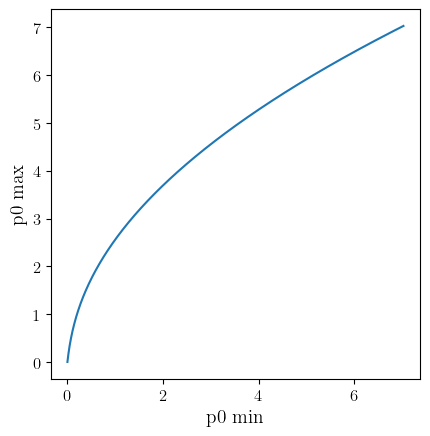

In [ ]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

ax.plot(test1, test2)
ax.set_xlabel('p0 min')
ax.set_ylabel('p0 max');